# CLIP with conformal prediction

Comparing prediciton set size across different datasets

In [1]:
from pathlib import Path
from functools import partial
import pandas as pd
import matplotlib.pyplot as plt; plt.style.use('bmh')
import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
assert torch.cuda.is_available()
import open_clip
from tqdm import tqdm
from conformal import *
# import wilds

## datasets

In [2]:
# data_dir = Path('../data')
# cifar_train = datasets.CIFAR100(root=data_dir, download = True, train=True)
# cifar_test = datasets.CIFAR100(root=data_dir, download = True, train=False)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
cifar_test = 

In [3]:
cifar_classes = tuple(cifar_test.classes)
cifar_class_map = dict(map(reversed, cifar_test.class_to_idx.items()))

In [7]:
class DS(Dataset):
    def __init__(self, images, labels, transforms=None, target_transforms=None):
        assert len(images) == len(labels)
        self.images = images
        self.labels = labels
        self.transforms = transforms
        self.target_transforms = target_transforms
        
    def __getitem__(self, k):
        x = self.images[k]
        y = self.labels[k]
        if self.transforms is not None:
            x = self.transforms(x)
        if self.target_transforms is not None:
            y = self.target_transforms(y)
        return x, y
    
    def __len__(self):
        return len(self.images)
    

In [8]:
cifar_test_dataset = DS(
    cifar_test.data, cifar_test.targets,
    transforms=transforms.Compose([
        # transforms.ToTensor(),
        # transforms.Normalize((0.5071, 0.4865, 0.4409), (0.2673, 0.2564, 0.2762)),
        transforms.ToPILImage(),
    ]), 
)

loader_params = dict(batch_size=16, shuffle=False, pin_memory=True, num_workers=8)
cifar_test_loader = DataLoader(cifar_test_dataset, **loader_params)

In [9]:
from PIL import Image
def add_gaussian_noise(img, sigma):
    # Gaussian distribution parameters
    img = np.array(img)/255.0
    row, col, _ = img.shape
    noise =  np.random.normal(loc=0, scale=1, size=img.shape)
    noise_img = np.clip((img + noise*sigma),0,1)
    noise_img = Image.fromarray(np.uint8(noise_img*255))
    return noise_img

  0%|                                        | 10/10000 [00:00<05:13, 31.82it/s]


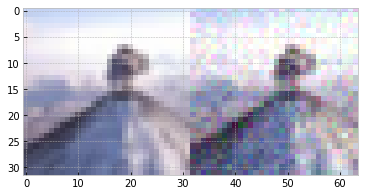

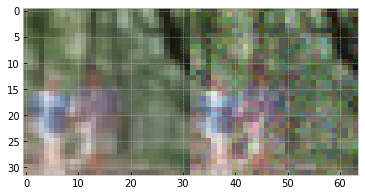

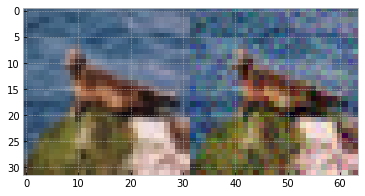

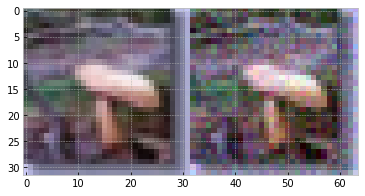

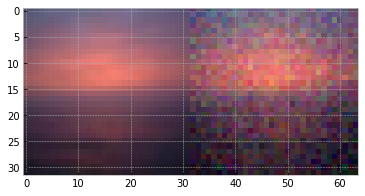

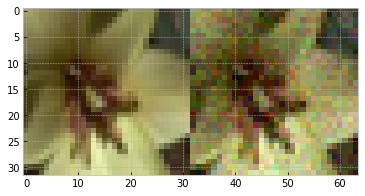

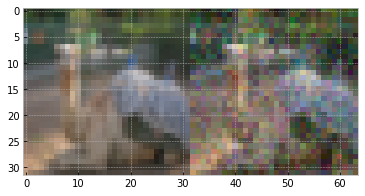

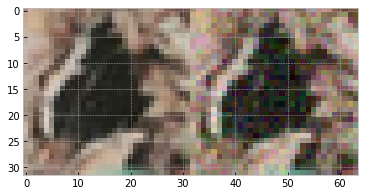

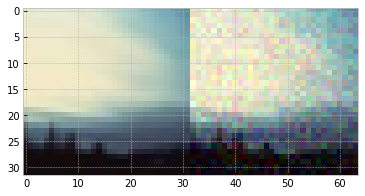

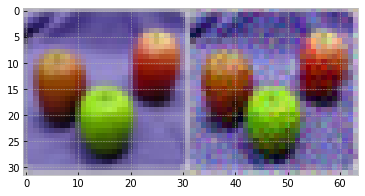

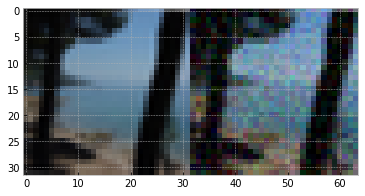

In [15]:
for i in tqdm(range(len(cifar_test_dataset))):
        x, y = cifar_test_dataset[i]
        noise_x = add_gaussian_noise(x, 0.05)
        plt.figure()
        plt.imshow(np.hstack((x, noise_x)))
        
        if i==10:
            break
        
        
        
        # image_features = model.encode_image(preprocess(noise_x).unsqueeze(0))
        # image_features /= image_features.norm(dim=-1, keepdim=True)
        # scores = (image_features @ text_features.T).softmax(dim=-1)

## CLIP model

In [10]:
tokenizer = open_clip.get_tokenizer('ViT-B-32-quickgelu')
model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-32-quickgelu', pretrained='laion400m_e32')

In [108]:
def zero_shot_clip(sigma):
    cifar_true_class = []
    cifar_pred_class = []
    cifar_pred_scores = []

    with torch.no_grad(), torch.cuda.amp.autocast():
        prompt = tokenizer(['This is an image of a ' + c for c in cifar_classes])
        text_features = model.encode_text(prompt)
        text_features /= text_features.norm(dim=-1, keepdim=True)

        for i in tqdm(range(len(cifar_test_dataset))):
            x, y = cifar_test_dataset[i]
            noise_x = add_gaussian_noise(x, sigma)
            image_features = model.encode_image(preprocess(noise_x).unsqueeze(0))
            image_features /= image_features.norm(dim=-1, keepdim=True)
            scores = (image_features @ text_features.T).softmax(dim=-1)

            cifar_true_class.append(y)
            cifar_pred_class.append(scores.argmax().item())
            cifar_pred_scores.append(scores.detach().cpu().numpy().squeeze())

    cifar_true_class = np.asarray(cifar_true_class)
    cifar_pred_class = np.asarray(cifar_pred_class)
    cifar_pred_scores = np.asarray(cifar_pred_scores)

    cifar_acc = (cifar_true_class == cifar_pred_class).sum() / cifar_true_class.shape[0]
    print(f'Adding Gaussian noise with sigma: {sigma:.2f}')
    print(f'CIFAR100 accuracy: {cifar_acc:.1%}')
    return cifar_true_class, cifar_pred_scores, cifar_acc

## Conformal prediction

In [109]:
frac = 0.1
alpha = 0.1
def conformal_clip(cifar_true_class, cifar_pred_scores):
    cifar_n = int(round(frac * len(cifar_pred_scores)))
    cifar_cal_scores = torch.tensor(cifar_pred_scores[:cifar_n])
    cifar_cal_targets = torch.tensor(cifar_true_class[:cifar_n])
    cifar_val_scores = torch.tensor(cifar_pred_scores[cifar_n:])
    cifar_val_targets = torch.tensor(cifar_true_class[cifar_n:])

    cifar_qhat = get_quantile(cifar_cal_scores, cifar_cal_targets, alpha=alpha)
    cifar_psets = make_prediction_sets(cifar_val_scores, cifar_qhat)
    cifar_psets_size = cifar_psets.sum(1)

    print(f'CIFAR100 coverage: {get_coverage(cifar_psets, cifar_val_targets):.1%}')
    print(f'CIFAR100 set size: {get_size(cifar_psets):.1f}')
    return cifar_psets_size


In [ ]:
sigmas = np.linspace(0, 0.2, 11)
accs = []
psets_sizes = []
for sigma in sigmas:
    cifar_true_class, cifar_pred_scores, cifar_acc = zero_shot_clip(sigma)
    cifar_psets_size = conformal_clip(cifar_true_class, cifar_pred_scores)
    accs.append(cifar_acc)
    psets_sizes.append(cifar_psets_size)

100%|█████████████████████████████████████| 10000/10000 [08:56<00:00, 18.64it/s]


Adding Gaussian noise with sigma: 0.0%
CIFAR100 accuracy: 68.6%
CIFAR100 coverage: 91.0%
CIFAR100 set size: 5.4


100%|█████████████████████████████████████| 10000/10000 [09:14<00:00, 18.03it/s]


Adding Gaussian noise with sigma: 10.0%
CIFAR100 accuracy: 16.1%
CIFAR100 coverage: 91.7%
CIFAR100 set size: 70.3


 89%|█████████████████████████████████▉    | 8923/10000 [08:40<01:05, 16.47it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

 72%|███████████████████████████▎          | 7180/10000 [06:56<02:39, 17.71it/s]

In [ ]:
psets_sizes

(array([ 0. ,  2.5,  5. ,  7.5, 10. , 12.5, 15. , 17.5, 20. ]),
 [Text(0.0, 0, '0.0'),
  Text(2.5, 0, '2.5'),
  Text(5.0, 0, '5.0'),
  Text(7.5, 0, '7.5'),
  Text(10.0, 0, '10.0'),
  Text(12.5, 0, '12.5'),
  Text(15.0, 0, '15.0'),
  Text(17.5, 0, '17.5'),
  Text(20.0, 0, '20.0')])

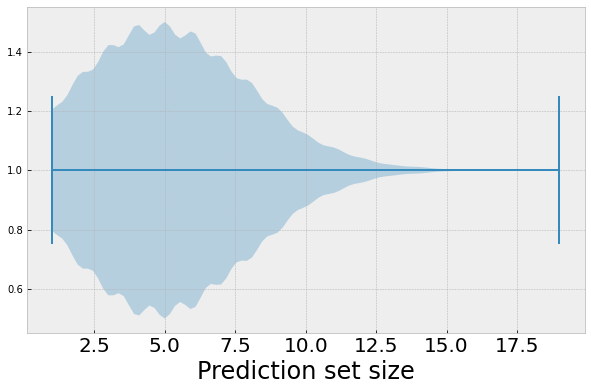

In [21]:
fontsize=24
plt.figure(figsize=(10, 6))
plt.violinplot(psets_sizes, vert=False, widths=1.0)
plt.xlabel('Prediction set size', fontsize=fontsize)
plt.xticks(fontsize=fontsize-4)
# plt.yticks(ticks=range(1, 4), labels=[f'CIFAR100', f'Mini-ImageNet\n(1000 classes)', f'WILDS\niWildCam\n({len(wild_classes)} classes)'], fontsize=fontsize-6)

In [13]:
np.linspace(0, 0.2, 5)

array([0.  , 0.05, 0.1 , 0.15, 0.2 ])

In [3]:
size = [1, 2,3, 4, 5]

In [4]:
sizes = [size, size]

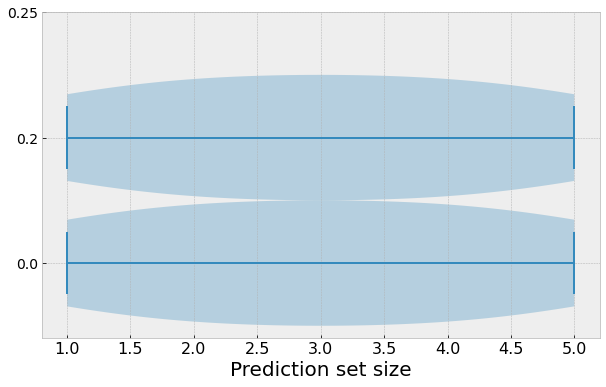

In [16]:
fontsize=24
simgas = [0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25]
plt.figure(figsize=(10, 6))
plt.violinplot(sizes, vert=False, widths=1.0)
plt.xlabel('Prediction set size', fontsize=fontsize)
plt.xticks(fontsize=fontsize-4)
plt.yticks(ticks=range(1, 4), labels=[str(i) for i in simgas], fontsize=fontsize-6)
plt.savefig('pset_noise')

<Figure size 432x288 with 0 Axes>

In [1]:
from pathlib import Path
from functools import partial
import pandas as pd
import matplotlib.pyplot as plt; plt.style.use('bmh')
import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
assert torch.cuda.is_available()
import os
import open_clip
from tqdm import tqdm
from PIL import Image
from conformal import *
from dataset import DS, DatasetC, load_txt
# import wilds

In [2]:
CORRUPTIONS = load_txt('corruptions.txt')
data_dir = Path('../data')
cifar_train = datasets.CIFAR100(root=data_dir, download = True, train=True)
cifar_test = datasets.CIFAR100(root=data_dir, download = True, train=False)
cifar_classes = tuple(cifar_test.classes)
cifar_class_map = dict(map(reversed, cifar_test.class_to_idx.items()))
transform = transforms.Compose([
                    # transforms.ToTensor(),
                    # transforms.Normalize((0.5071, 0.4865, 0.4409), (0.2673, 0.2564, 0.2762)),
                    transforms.ToPILImage(),
                ])


Files already downloaded and verified
Files already downloaded and verified


In [14]:
cifar_test_dataset = DS(
                cifar_test.data, cifar_test.targets,
                transforms=transform
            )

In [3]:
cifar_test_dataset = DatasetC(
                os.path.join('../data', 'CIFAR-10-C'),
                'gaussian_noise', transforms=transform
            )

In [ ]:
len(cifar_test_dataset)

In [5]:
x, y = cifar_test_dataset.__getitem__(1)

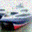

In [6]:
x

In [5]:
torch.tensor(y)

NameError: name 'y' is not defined

In [7]:
type(y)

numpy.uint8

In [24]:
cifar_test_dataset

AttributeError: 'DatasetC' object has no attribute 'shape'

In [20]:
len(cifar_test_dataset)

50000

In [10]:
x, y = cifar_test_dataset.__getitem__(49999)

IndexError: index 49999 is out of bounds for axis 0 with size 10

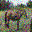

In [22]:
x

In [9]:
dtype(y)

NameError: name 'dtype' is not defined

In [1]:
for level in range(1, 5):
    print(level)

1
2
3
4


In [2]:
cname = 'eys'
noise_level = 1
print('corrupion with ', cname, ' with level ', noise_level)

corrupion with  eys  with level  1
